In [21]:
### import all the neccessary libries
import tensorflow as tf 
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re
import nltk
from nltk.corpus import stopwords

## download neccesarry resoucres
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [22]:
## loading the dataset 
data = pd.read_csv('data/Symptom2Disease.csv') 

In [23]:
def remove_digits(text):
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' 
    #when the ^ is on the inside of []; we are matching any character that is not included in this expression within the []
    return re.sub(pattern, '', text)

def remove_special_characters(text):
    pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]'   # define the pattern to keep
    return re.sub(pattern, '', text)

def non_ascii(s):
  return "".join(i for i in s if ord(i)<128)

def non_ascii(s):
  return "".join(i for i in s if ord(i)<128)

def lower(text):
  return text.lower()

## function to remove stop words. 
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in text.split() if word not in stop_words]
    return ' '.join(tokens)

In [24]:
def clean_data(df, col): 
    df[col] = df[col].apply(remove_digits)
    df[col] = df[col].apply(remove_special_characters)
    df[col] = df[col].apply(non_ascii)
    df[col] = df[col].apply(lower)
    return df
    

In [25]:
df = clean_data(data, 'text')

In [26]:
df.head()

,Unnamed: 0,label,text
0,0,Psoriasis,i have been experiencing a skin rash on my arm...
1,1,Psoriasis,"my skin has been peeling, especially on my kne..."
2,2,Psoriasis,i have been experiencing joint pain in my fing...
3,3,Psoriasis,"there is a silver like dusting on my skin, esp..."
4,4,Psoriasis,"my nails have small dents or pits in them, and..."


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1200 non-null   int64 
 1   label       1200 non-null   object
 2   text        1200 non-null   object
dtypes: int64(1), object(2)
memory usage: 28.3+ KB


In [28]:
df.duplicated().sum()

0

In [29]:
labels = df['label']
text = df['text']

## encoding the labels. 
encoder = LabelEncoder()
labels = encoder.fit_transform(labels)

### removing stop words before breaking into test and training data set. 
text = text.apply(remove_stopwords)

In [30]:
encoder.classes_

array(['Acne', 'Arthritis', 'Bronchial Asthma', 'Cervical spondylosis',
       'Chicken pox', 'Common Cold', 'Dengue', 'Dimorphic Hemorrhoids',
       'Fungal infection', 'Hypertension', 'Impetigo', 'Jaundice',
       'Malaria', 'Migraine', 'Pneumonia', 'Psoriasis', 'Typhoid',
       'Varicose Veins', 'allergy', 'diabetes', 'drug reaction',
       'gastroesophageal reflux disease', 'peptic ulcer disease',
       'urinary tract infection'], dtype=object)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(text, labels, test_size=0.2, random_state=42,)

In [32]:
## further preprocessing of our training dataset
tokenize = Tokenizer(num_words=10000, oov_token='<00V>')
tokenize.fit_on_texts(X_train)
X_train = tokenize.texts_to_sequences(X_train)
word_indexes = tokenize.word_index

# Determine maxlen from training data
max_len = max(len(seq) for seq in X_train)
X_train_padded = pad_sequences(X_train, maxlen=max_len, padding='post')

In [33]:
# further preprocessing for our test data 
X_test = tokenize.texts_to_sequences(X_test)

# Determine maxlen from training data
max_len = max(len(seq) for seq in X_test)
X_test_padded = pad_sequences(X_test, maxlen=max_len, padding='post')

In [34]:
## let's define some variables 

embedding_dimession = 50
input_dim = len(word_indexes)
ouput_layer = len(encoder.classes_)
#modeling
model = keras.Sequential([
    keras.layers.Embedding(10000, embedding_dimession),
    #keras.layers.LSTM(64, return_sequences=False),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(ouput_layer, activation='softmax')
])

In [35]:
## compiling the model 
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [36]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True)

history = model.fit(
    X_train_padded, y_train,
    epochs = 100, 
    validation_data = (X_test_padded, y_test),
    callbacks = [early_stopping],
    batch_size=512,
    verbose = 2
)

Epoch 1/100
2/2 - 8s - 4s/step - accuracy: 0.0490 - loss: 3.1758 - val_accuracy: 0.0667 - val_loss: 3.1766
Epoch 2/100
2/2 - 1s - 380ms/step - accuracy: 0.0865 - loss: 3.1400 - val_accuracy: 0.0875 - val_loss: 3.1752
Epoch 3/100
2/2 - 0s - 183ms/step - accuracy: 0.1219 - loss: 3.1026 - val_accuracy: 0.0583 - val_loss: 3.1734
Epoch 4/100
2/2 - 0s - 162ms/step - accuracy: 0.1802 - loss: 3.0606 - val_accuracy: 0.0625 - val_loss: 3.1713
Epoch 5/100
2/2 - 0s - 160ms/step - accuracy: 0.1896 - loss: 3.0168 - val_accuracy: 0.0583 - val_loss: 3.1686
Epoch 6/100
2/2 - 0s - 108ms/step - accuracy: 0.2302 - loss: 2.9621 - val_accuracy: 0.0542 - val_loss: 3.1652
Epoch 7/100
2/2 - 0s - 78ms/step - accuracy: 0.2635 - loss: 2.9090 - val_accuracy: 0.0542 - val_loss: 3.1610
Epoch 8/100
2/2 - 0s - 81ms/step - accuracy: 0.2896 - loss: 2.8343 - val_accuracy: 0.0500 - val_loss: 3.1560
Epoch 9/100
2/2 - 0s - 79ms/step - accuracy: 0.3000 - loss: 2.7635 - val_accuracy: 0.0667 - val_loss: 3.1496
Epoch 10/100
2/2

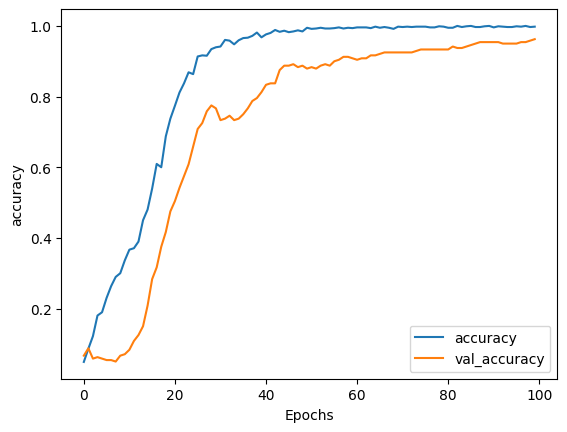

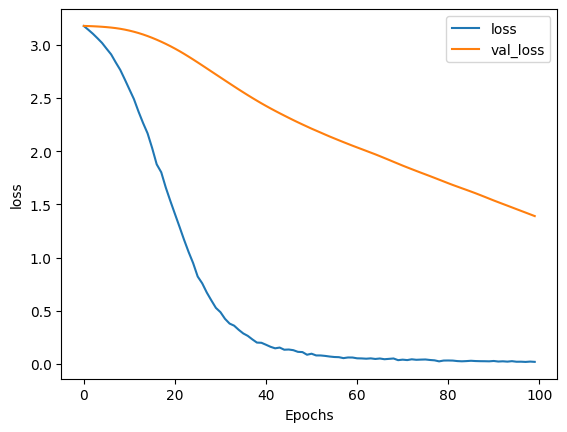

In [37]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [38]:
predictions = model.predict(X_test_padded)

# Convert probabilities to class labels
predicted_labels_ = np.argmax(predictions, axis=1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step


In [39]:
# Inverse transform the predicted labels
predicted_labels = encoder.inverse_transform(predicted_labels_)

In [40]:
np.sum(predicted_labels == y_test) / len(y_test)

0.0

In [41]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, predicted_labels_)

0.9625